In [1]:
import os
import os.path
import sys
from tqdm import tqdm

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import numba
#import umap

import scvi
from scvi.model import CondSCVI
from scvi.model import DestVI
import torch

## Assign cluster info to each barcode

In [89]:
# PBN_4_cluster.csv from Figure3C.R
PBN_4_cluster_File = open("/media/gulab/GUDR2/PB10_new/PBN_4_cluster.csv") 
PBN_4_cluster_line = PBN_4_cluster_File.readlines()
dict_barcode2cluster = {}
for i in tqdm(range(1, len(PBN_4_cluster_line))):
    tmp_lst = PBN_4_cluster_line[i].strip('\n').replace('\"', '').split(',')
    dict_barcode2cluster[tmp_lst[0][8:]] = int(tmp_lst[1])
PBN_4_cluster_File.close()

100%|██████████| 63808/63808 [00:00<00:00, 1194073.80it/s]


In [90]:
for key, value in dict_barcode2cluster.items():
    if value == 2:
        dict_barcode2cluster[key] = 18
    if value == 3:
        dict_barcode2cluster[key] = 19
    if value == 4:
        dict_barcode2cluster[key] = 20
    if value == 13:
        dict_barcode2cluster[key] = 21
    if value == 18:
        dict_barcode2cluster[key] = 22
    if value == 19:
        dict_barcode2cluster[key] = 23
    if value == 6:
        dict_barcode2cluster[key] = 24
    if value == 9:
        dict_barcode2cluster[key] = 25
    if value == 12:
        dict_barcode2cluster[key] = 26
    if value == 11:
        dict_barcode2cluster[key] = 27
    if value == 17:
        dict_barcode2cluster[key] = 28
    if value == 20:
        dict_barcode2cluster[key] = 29

In [95]:
# neuron_4_cluster.csv from Figure3F.R
with open("/media/gulab/GUDR2/PB10_new/neuron_4_cluster.csv") as NeuroFile:
    for line in NeuroFile.readlines()[1:]:
        tmp_lst = line.strip('\n').replace('\"', '').split(';')
        dict_barcode2cluster[tmp_lst[0][8:]] = int(tmp_lst[1])

## caculate PCCF on 30d1

In [96]:
dict_coord2id = {}
dict_id2count = {}
# idAssignBarcode_30d1_S2.txt from Xiaonan
# PBS2_30d1_edge.txt from Xiaonan
# spt_4U_p2Mask30d1_S2Coord.txt from Xiaonan
idAssignFile_30d1 = open("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/idAssignBarcode_30d1_S2.txt")
idAssignLines_30d1 = idAssignFile_30d1.readlines()
for i in tqdm(range(len(idAssignLines_30d1))):
    tmp_lst = idAssignLines_30d1[i].strip('\n').split('\t')
    tmp_coord = (float(tmp_lst[0]), float(tmp_lst[1]))
    tmp_id = int(tmp_lst[2])
    dict_coord2id[tmp_coord] = tmp_id
    if tmp_id not in dict_id2count.keys():
        dict_id2count[tmp_id] = 1
    else:
        dict_id2count[tmp_id] = dict_id2count[tmp_id] + 1
dict_id2count[0] = 0

EdgeFile = open("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/PBS2_30d1_edge.txt")
EdgeLines = EdgeFile.readlines()
dict_cellidpair2connect = {}
for i in tqdm(range(1, len(EdgeLines))):
    tmp_lst = EdgeLines[i].strip('\n').split('\t')
    tmp_coord_1 = (float(tmp_lst[2]), float(tmp_lst[3]))
    tmp_coord_2 = (float(tmp_lst[4]), float(tmp_lst[5]))
    id1 = dict_coord2id[tmp_coord_1]
    id2 = dict_coord2id[tmp_coord_2]
    if id1 < id2:
        dict_cellidpair2connect[(id1, id2)] = 1
    elif id2 > id1:
        dict_cellidpair2connect[(id2, id1)] = 1
        
CoordFile = open("/media/gulab/GUDR2/PB10_new/PBS2_edgeSegID/spt_4U_p2Mask30d1_S2Coord.txt")
CoordLines = CoordFile.readlines()
dict_id2barcode = {}
dict_barcodeCount = {}
cluster_lst = []
counts_lst = []
count = 0
for i in tqdm(range(1, len(CoordLines))):
    tmp_lst = CoordLines[i].strip('\n').split(',')
    dict_id2barcode[int(tmp_lst[0])] = tmp_lst[3]
    if tmp_lst[3] in dict_barcode2cluster.keys():
        tmp_cluster = dict_barcode2cluster[tmp_lst[3]]
        cluster_lst.append(tmp_cluster)
        counts_lst.append(dict_id2count[int(tmp_lst[0])-1])
        if tmp_cluster not in dict_barcodeCount.keys():
            dict_barcodeCount[tmp_cluster] = 1
        else:
            dict_barcodeCount[tmp_cluster] = dict_barcodeCount[tmp_cluster] + 1
    else:
        count = count + 1
print(count)

from sklearn.neighbors import NearestNeighbors
import random
import numpy as np

n_iter = 100
n_img_size = 8826
dict_est_1 = {}
for n in tqdm(range(n_iter)):
    coord_lst = []
    for i in range(len(counts_lst)):
        x_coord = random.randint(0, n_img_size-1)
        y_coord = random.randint(0, n_img_size-1)
        coord_lst.append((x_coord, y_coord))
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coord_lst)
    distances, indices = nbrs.kneighbors(coord_lst)
    for i in range(len(distances)):
        tmp_index = indices[i][1]
        r_1 = np.square(counts_lst[i])
        r_2 = np.square(counts_lst[tmp_index])
        if distances[i][1] <= r_1 + r_2:
            tmp_pair = ""
            if cluster_lst[i] <= cluster_lst[tmp_index]:
                tmp_pair = (cluster_lst[i], cluster_lst[tmp_index])
            else:
                tmp_pair = (cluster_lst[tmp_index], cluster_lst[i])
            if tmp_pair not in dict_est_1.keys():
                dict_est_1[tmp_pair] = 1
            else:
                dict_est_1[tmp_pair] = dict_est_1[tmp_pair] + 1
for item in list(dict_est_1):
    dict_est_1[item] = dict_est_1[item] / 100
    
dict_paircluster2count_1 = {}
count = 0
for item in list(dict_cellidpair2connect):
    tmp_id_1 = item[0]
    tmp_id_2 = item[1]
    if tmp_id_1 in dict_id2barcode.keys() and tmp_id_2 in dict_id2barcode.keys():
        tmp_barcode_1 = dict_id2barcode[tmp_id_1]
        tmp_barcode_2 = dict_id2barcode[tmp_id_2]
        if tmp_barcode_1 in dict_barcode2cluster.keys() and tmp_barcode_2 in dict_barcode2cluster.keys():
            tmp_cluster_1 = dict_barcode2cluster[tmp_barcode_1]
            tmp_cluster_2 = dict_barcode2cluster[tmp_barcode_2]
            tmp_pair = ""
            if tmp_cluster_1 <= tmp_cluster_2:
                tmp_pair = (tmp_cluster_1, tmp_cluster_2)
            else:
                tmp_pair = (tmp_cluster_2, tmp_cluster_1)
            if tmp_pair not in dict_paircluster2count_1:
                dict_paircluster2count_1[tmp_pair] = 1
            else:
                dict_paircluster2count_1[tmp_pair] = dict_paircluster2count_1[tmp_pair] + 1
        else:
            count = count + 1
print(count)



  1%|          | 1/100 [00:00<00:14,  6.60it/s]

352


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]

87


# Caculate Ratio 

In [111]:
dict_ratio_1 = {}
for i in range(29):
    for j in range(29):
        if i<=j:
            count_obs = 0.0
            if (i, j) in dict_paircluster2count_1.keys():
                count_obs = count_obs + dict_paircluster2count_1[(i, j)]

            count_est = 0.0
            if (i, j) in dict_est_1.keys():
                count_est = count_est + dict_est_1[(i, j)]

            #print(str(i)+" "+str(j)+" "+str(count_obs)+" "+str(count_est))
            if count_est >= 2 and count_obs >= 2:
                dict_ratio_1[(i, j)] = count_obs / count_est

In [112]:
matrix_outpt = open("/media/gulab/GUDR2/PB10_new/matrix_30d1.lst", "w")
matrix_np = np.zeros((29, 29))
for i in range(29):
    for j in range(29):
        if (j, i) in dict_ratio.keys():
            matrix_np[i][j] = dict_ratio[(j, i)]
            matrix_outpt.write(str(matrix_np[i][j])+",")
        else:
            matrix_outpt.write("0,")
    matrix_outpt.write('\n')
matrix_outpt.close()

In [113]:
matrix_File = open("/media/gulab/GUDR2/PB10_new/matrix_30d1.lst")
matrix_Lines = matrix_File.readlines()
matrix_np = []
for i in range(len(matrix_Lines)):
    tmp_lst = matrix_Lines[i].strip('\n').split(',')[:-1]
    for j in range(len(tmp_lst)):
        tmp_lst[j] = float(tmp_lst[j])
    matrix_np.append(tmp_lst)

In [114]:
for i in range(len(matrix_np)):
    for j in range(len(matrix_np)):
        if matrix_np[i][j] == 0:
            matrix_np[i][j] = matrix_np[j][i]

## generate heatmap

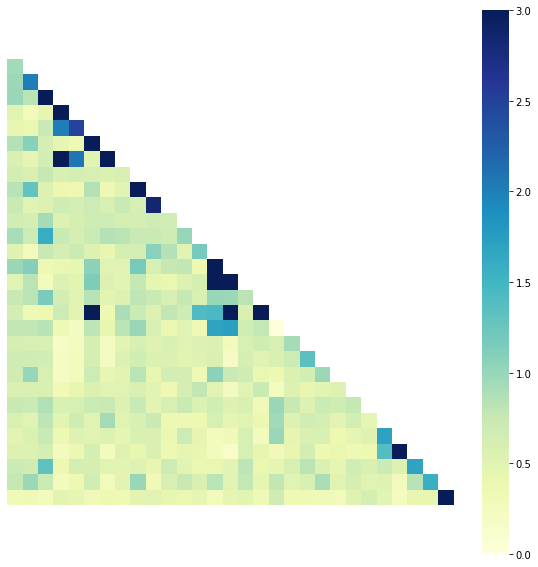

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matrix_np = pd.DataFrame(matrix_np)
df_lt = matrix_np.where(np.tril(np.ones(matrix_np.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_lt, vmin= 0, vmax= 5, cmap="YlGnBu", square = True, xticklabels=False, yticklabels=False)
plt.savefig('/media/gulab/GUDR2/PB10_new/Only_PBN_30d1.png',
           dpi=300)